In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn .linear_model import LogisticRegression
from mlxtend .feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import learning_curve
from skrebate import MultiSURF
from keras.models import Sequential
from keras.layers import Dense
import sys

In [4]:
pd.set_option("display.max_columns",3000)  #this allows us to view up to 3000 columns when printing a dataframe
pd.set_option("display.max_rows",3000)  #this allows us to view up to 3000 rows when printing a dataframe

### Reading the training and test dataset file

##### I have used the "frameWidth" field as a TARGET to train the model

#### Func-1: Method to be used in the dataset (grouping or reducing):

In [3]:
def meth(meth_type):
    global dataFrame
    global dataFrame_1
    
    dataFrame=pd.read_csv("Train_1000ms_unbalanced.csv")  #reading train dataSet file
    dataFrame_1=pd.read_csv("Test_1000ms_unbalanced.csv")  #reading test dataSet file
    # print("Coming to method type")
    if meth_type=="group":
        # print("grouping method selected")
        dataFrame.loc[dataFrame['frameWidth'] == -1, 'frameWidth'] = 0             #For every farmeWidth value equal to -1 change it to 0
        dataFrame.loc[(dataFrame['frameWidth'] >= 240) & (dataFrame['frameWidth'] <= 480), 'frameWidth'] = 1
        dataFrame.loc[(dataFrame['frameWidth'] > 480) & (dataFrame['frameWidth'] <= 960), 'frameWidth'] = 2
        dataFrame.loc[(dataFrame['frameWidth'] > 960) & (dataFrame['frameWidth'] <= 1280), 'frameWidth'] = 3
        dataFrame.loc[(dataFrame['frameWidth'] > 1280) & (dataFrame['frameWidth'] <= 1866), 'frameWidth'] = 4
        dataFrame.loc[dataFrame['frameWidth'] > 1866, 'frameWidth'] = 5
        dataFrame = dataFrame[~(dataFrame["frameWidth"] == 0)]    #Drop all data corresponding to frameWidth=0
        dataFrame.groupby("frameWidth").size()
    
        dataFrame_1.loc[dataFrame_1['frameWidth'] == -1, 'frameWidth'] = 0
        dataFrame_1.loc[(dataFrame_1['frameWidth'] >= 240) & (dataFrame_1['frameWidth'] <= 480), 'frameWidth'] = 1
        dataFrame_1.loc[(dataFrame_1['frameWidth'] > 480) & (dataFrame_1['frameWidth'] <= 960), 'frameWidth'] = 2
        dataFrame_1.loc[(dataFrame_1['frameWidth'] > 960) & (dataFrame_1['frameWidth'] <= 1280), 'frameWidth'] = 3
        dataFrame_1.loc[(dataFrame_1['frameWidth'] > 1280) & (dataFrame_1['frameWidth'] <= 1866), 'frameWidth'] = 4
        dataFrame_1.loc[dataFrame_1['frameWidth'] > 1866, 'frameWidth'] = 5
        dataFrame_1 = dataFrame_1[~(dataFrame_1["frameWidth"] == 0)]
        dataFrame_1.groupby("frameWidth").size()
        
    elif meth_type=="reduce":
        # print("reduction method selected")
        # Extracting rows belonging to classes with less than 1000 samples
        dataFrame=dataFrame[~((dataFrame["frameWidth"] == 360) | (dataFrame["frameWidth"] == 480) | (dataFrame["frameWidth"] == 1400) |(dataFrame["frameWidth"] == 1866) | (dataFrame["frameWidth"] == 3440) | (dataFrame["frameWidth"] == 1920) | (dataFrame["frameWidth"] == 1200))]
        dataFrame_1=dataFrame_1[~((dataFrame_1["frameWidth"] == 360) | (dataFrame_1["frameWidth"] == 480) | (dataFrame_1["frameWidth"] == 1400) | (dataFrame_1["frameWidth"] == 1866) | (dataFrame_1["frameWidth"] == 1920) | (dataFrame_1["frameWidth"] == 3440) | (dataFrame_1["frameWidth"] == 1200))]

        #remove also the AUDIO packets
        dataFrame = dataFrame[~(dataFrame["frameWidth"] == -1)]
        dataFrame.groupby("frameWidth").size()

        dataFrame_1 = dataFrame_1[~(dataFrame_1["frameWidth"] == -1)]
        dataFrame_1.groupby("frameWidth").size()
   

## PREDICTION_2: RESOLUTION

#### There have been used some functions below in order to simplify the process for re-running the model many times with different algorithms and parameters

#### Func-2: Definition of the training and test dataset

In [4]:
def inp_data():
    global X_train
    global X_test
    global y_train
    global y_test
    global X_train_scaled
    global X_test_scaled
    
    #Selection of all training data I thought it would be useful to count on:
    drp_1=dataFrame.iloc[:,0:27]
    drp_2=dataFrame.loc[:,"flow":"p_type"]
    X_train = dataFrame.drop(drp_1+drp_2,axis=1) #axis=0 indicates rows, axis=1 indicates columns
    X_train = X_train.drop(X_train.loc[:,'rtp_csrc_csrc_agg':'inter_time_sequence_max_value_count_percent'],axis=1)
    
    X_test = dataFrame_1.loc[:, X_train.columns]
    
    y_train=dataFrame["frameWidth"]
    y_test = dataFrame_1["frameWidth"]
    
    y_train = y_train.dropna()
    y_test = y_test.dropna()
    X_train = X_train.loc[y_train.index]
    X_test = X_test.loc[y_test.index]    
    
    #Preprocess the dataset (Without OUTLIERS)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Check if rows of X_train_aud do match with those of y_train_aud
    #print((y_train.index==X_train.index).all())
    
    #print("First Step done")

### Outliers processing

In [5]:
def outlr(out_value, out_meth):
    
    #use "global" in order to be able to modify a previously defined global varible inside a function
    global X_train
    global y_train
    global X_rem
    
    if out_meth=="IQR":# Identify the Outliers by using Inter-Quartile Range (IQR) proximity rule (this rule is used for skewed distribution of data, or the so called assymetric distributions)
            
        #print("Outliers are being removed")
        #Triming method using IQR score
        print(f"Outliers are being identified with {out_meth}")
            
        treat=input("how do u want to treat the outliers: (remove, or replace)")
            
        #from pandas import DataFrame
        #print("Outliers are being removed")
        #Triming method using IQR score
        print("Outliers are being identified")
            

        for column in X_train.columns:
            #print(f"column being executed is {column}")            
            Q1 = X_train[column].quantile(0.25)
            Q3 = X_train[column].quantile(0.75)
            IQR1 = Q3 - Q1
            low = Q1 - (1.5 * IQR1)
            high = Q3 + (1.5 * IQR1)
            
                
            if treat=="replace":
                #Method-1: Replace outliers with MEDIAN values (not recomended, also not giving good results in our model)
                #med = X_train.loc[((X_train[column] < (Q1 - 1.5 * IQR1)) | (X_train[column] > (Q3 + 1.5 * IQR1))), column].median()
                # Above line means to find the median for each column without taking into account the outliers
                
                #med = X_train.loc[((X_train[column] > (Q1 - 1.5 * IQR1)) | (X_train[column] < (Q3 + 1.5 * IQR1))), column].median()
                #Above line clearly replaces the outlier values with the median, so if the conditiion is met it replaces with median if not writes the same value. This is how np.where works
    
    
                #Method-2: Using FLOORING and CAPPING method which means to replace outliers with min for outliers lower than min and with max for those higher than max
                X_train[column] = np.where((X_train[column] < (Q1 - 1.5 * IQR1)), low, np.where((X_train[column] > (Q3 + 1.5 * IQR1)), high,X_train[column]))
                #Above line clearly replaces the outlier values higher than max with max allowed and min outliers with min value allowed, 
                #so basically if the conditiion is met it replaces it with the next value if not let it as it is (the last value inside .where function which is X_train[column]). This is how np.where works
    
            elif treat=="remove":
                #print("REMOVING method being used")
                X_train[column] = np.where(((X_train[column] < (Q1 - 1.5 * IQR1)) | (X_train[column] > (Q3 + 1.5 * IQR1))), np.nan,X_train[column])
                X_train = X_train.loc[X_train[column].index]
        
        
        if treat=="remove":
            #print("outliers before being removed: ",X_train.isnull().sum())
            X_train = X_train.dropna(axis = 0)   #Remove the NaN values (which are actually outliers but were substituted with NaN for simplicity)
            #print("outliers after being removed: ",X_train.isnull().sum())

        
        y_train = y_train.loc[X_train.index]
        print((y_train.index==X_train.index).all())
            
            # Coment: If we do not remove outliers in the TEST as well, the performance becomes even worse compared to the case where outliers were not removed
            # The reason for the case above might be due to underfitting, so when outliers are removed there are less data for model training.

            
    elif out_meth=="z-score":              # Identify the outliers by using empirical relations for Normal distribution (assuming that our dataset is normally distributed)
        #print("Training dataset size before removing outliers: ",X_train.shape)
        
        print(f"Outliers are being identified with {out_meth}")    
        treat=input("how do u want to treat the outliers: (remove, or replace)")
 
        for column in X_train.columns:
            
            highest_limit=(X_train[column].mean() + 3*X_train[column].std())
            lowest_limit=(X_train[column].mean() - 3*X_train[column].std())
            
            if treat=="replace":
                X_train[column] = np.where((X_train[column] < lowest_limit), lowest_limit, np.where((X_train[column] > highest_limit), highest_limit,X_train[column]))

                
                #X_train[column] = np.where((X_train[column] < lowest_limit, lowest_limit, np.where(X_train[column] > highest_limit,highest_limit,X_train[column])))
                
            elif treat=="remove":
                #print("REMOVING method being used")
                X_train[column] = np.where(((X_train[column] < lowest_limit ) | (X_train[column] > highest_limit )), np.nan,X_train[column])
                X_train = X_train.loc[X_train[column].index]
    
        if treat=="remove":
            #print("outliers before being removed: ",X_train.isnull().sum())
            X_train = X_train.dropna(axis = 0)   #Remove the NaN values (which are actually outliers but were substituted with NaN for simplicity)
            #print("outliers after being removed: ",X_train.isnull().sum())
        
        y_train = y_train.loc[X_train.index]
        print((y_train.index==X_train.index).all())
            
        # COMENT: Also here the removal of outliers only in training part makes the performace even worse. See it seems these removing outliers techniques is not recommended due to the negative impacts it has.
        # This may be same reason as above but also becasue what we remove isn't actually an outlier. That's why we get worsening in performance

#### Func-3: Feature Selection method 

In [6]:
def feat_sel(feat_val):
    global X_train
    global X_test
    global y_train
    global y_test
    
    # Apply feature selection method
    if feat_val == "ExtraTree":
        model = ExtraTreesClassifier()
        model.fit(X_train,y_train)
        # print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
        #plot graph of feature importances for better visualization
        feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    
        X_train=X_train.loc[:,feat_importances.nlargest(35).index]        #Use the best 35 fields/columns of the X_train
        #X_test=X_test.loc[:,X_train.columns]  
        y_train = y_train.loc[X_train.index]
        X_test = X_test[X_train.columns]
        y_test = y_test.loc[X_test.index]
        
        print(f'Reduced number of features after {feat_val} selection method:', X_train.shape)
        
        
    elif feat_val == "infoGain":
        importances = mutual_info_classif(X_train,y_train)
        feat_imp=pd.Series(importances, index=X_train.columns)
        #print(feat_imp.nlargest(30).index)
    
        X_train=X_train.loc[:,feat_imp.nlargest(35).index]        #Use the best 35 fields/columns of the X_train
        #X_test=X_test.loc[:,X_train.columns]
        y_train = y_train.loc[X_train.index]
        X_test = X_test[X_train.columns]
        y_test = y_test.loc[X_test.index]
        
        print(f'Reduced number of features after {feat_val} selection method:', X_train.shape)

        
    elif feat_val == "corrCoeff":
        cor = X_train.corr()                                   # Apply correlation coefficient
        columns = np.full((cor.shape[0],), True, dtype=bool)
        for i in range(cor.shape[0]):
            for j in range(i+1, cor.shape[0]):
                if cor.iloc[i,j] >= 0.95:                      #Select only the fields having a correlation less than 95%
                    if columns[j]:
                        columns[j] = False
        selected_columns = X_train.columns[columns]
        X_train = X_train[selected_columns]
        y_train = y_train.loc[X_train.index]
        X_test = X_test[X_train.columns]
        y_test = y_test.loc[X_test.index]
        
        print(f'Reduced number of features after {feat_val} selection method:', X_train.shape)

        
    elif feat_val == "anova_f":
        fvalue_Best = SelectKBest(f_classif, k=30)
        X_kbest = fvalue_Best.fit_transform(X_train, y_train)
        X_train = X_train[X_train.columns[fvalue_Best.get_support()]]    #Use only the fields selected by the feature selection method called "ANOVA F-VALUE"
        y_train = y_train.loc[X_train.index]
        X_test = X_test[X_train.columns]
        y_test = y_test.loc[X_test.index]

        print(f'Reduced number of features using {feat_val} method:', X_kbest.shape)

#### Func-4: Decision Tree algorithm Implementation

In [7]:
def dec_tree():    
    de_tree = DecisionTreeClassifier()  #enable the decision tree Classifier
    de_tree.fit(X_train,y_train)  #fit the model with x_train and y_train
    predictions = de_tree.predict(X_test)
    
    #Evaluation process
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test,predictions))
    print("Accuracy score is:", accuracy_score(y_test, predictions))
    

#### Func-5: XGBOOST algorithm implementation

In [8]:
def xg_bst():
    
    #Training the model
    xgb_model = XGBClassifier().fit(X_train,y_train)
    # predict
    xgb_y_predict = xgb_model.predict(X_test)
    
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    print(confusion_matrix(y_test,xgb_y_predict))
    print(classification_report(y_test,xgb_y_predict))
    print("Accuracy score is:", accuracy_score(y_test, xgb_y_predict))

#### Func-6: Random Forest algorithm

In [9]:
def rand_for():    
    r_forest = RandomForestClassifier()  #enable the Random Forest Classifier
    r_forest.fit(X_train,y_train)  #fit the model with x_train and y_train
    predictions = r_forest.predict(X_test)
    
    #Evaluation process
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test,predictions))
    print("Accuracy score is:", accuracy_score(y_test, predictions))

#### Func-7: Learning Curve Plot

In [10]:
def lear_cur(est):
    train_sizes=[1,1000,10000,35000,75000,100000]     #These are the indexes of X_train data to be used to vary
    
    print("LEARNING CURVE BEING EXECUTED")
    if est=="decisionTree":
        est = DecisionTreeClassifier()
    elif est=="randomForest":
        est = RandomForestClassifier()
    elif est=="xgboost":
        est = XGBClassifier()
    
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator = est,
    X = X_train,
    y = y_train, train_sizes = train_sizes, cv = 5,
    shuffle=False,
    scoring = 'accuracy')
    # estimator — indicates the learning algorithm we use to estimate the true model;
    # X — the data containing the features;
    # y — the data containing the target;
    # train_sizes — specifies the training set sizes to be used;
    # cv — determines the cross-validation splitting strategy (we’ll discuss this immediately);
    # scoring — indicates the error metric to use; the intention is to use the mean squared error (MSE) metric, but that’s not a possible parameter for scoring; we’ll use the nearest proxy, negative MSE, and we’ll just have to flip signs later on.
   

    # Here we take the average of each score above (there are 5 because of cv=5 which iterates 5 times and gives 5 different MSE values)
    # Note that the scoring type used is "accuracy" instead of "MSE" used in regression
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
    print('\n', '-' * 20) # separator
    print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
    
    
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training accuracy curve')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation accuracy curve')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(f'Learning curves for {est} model', fontsize = 18, y = 1.03)
    plt.legend()

#### Func-8: Main function (Manual Run)

In [11]:
def res_pred():                                                                 #create the function    
    
    mt = input("which method do you want to use (select among: group, or reduce)")  # decide which method to use, grouping the close classes together (group) or dropping classes below a threshold (reduce)
    meth(mt)
    
    alg=input("Algorithm to be used(decisionTree, xgboost, randomForest): ")    #Ask for user input    
    outlier=input("Do you want to process the outliers(yes or no): ")
    #outlier_val=input("Which method do you want to use (IQR or z-score): ")
    
    if alg == "decisionTree":                                                   #Check the input value and accordingly apply the next steps
        print(f"We are using {alg} algorithm")
        if outlier == "yes":
            inp_data()
            outlier_val=input("Which method do you want to use (IQR or z-score): ")
            outlr(outlier, outlier_val)
            feat=input("Do you want to do feature selection (yes or no): ")
            if feat == "yes":              
                    feat_val=input("which feature selection method do you want to use (ExtraTree, infoGain, corrCoeff. anova_f): ")
                    feat_sel(feat_val)              
                    #lear_cur(alg)
                    dec_tree()
                
            elif feat == "no":
                #lear_cur(alg)
                dec_tree()
                print("END of DecisionTree execution")
        
        elif outlier == "no":
            inp_data()
            feat=input("Do you want to do feature selection (yes or no): ")
            if feat == "yes":              
                    feat_val=input("which feature selection method do you want to use (ExtraTree, infoGain, corrCoeff. anova_f): ")
                    feat_sel(feat_val)              
                    #lear_cur(alg)
                    dec_tree()
                
            elif feat == "no":
                #lear_cur(alg)
                dec_tree()
                print("END of DecisionTree execution")
        
            
    elif alg == "randomForest":
        print(f"We are using {alg} algorithm")
        if outlier == "yes":
            inp_data()
            outlier_val=input("Which method do you want to use (IQR or z-score): ")
            outlr(outlier, outlier_val)
            feat=input("Do you want to do feature selection (yes or no): ")
            if feat == "yes":              
                    feat_val=input("which feature selection method do you want to use (ExtraTree, infoGain, corrCoeff. anova_f): ")
                    feat_sel(feat_val)              
                    #lear_cur(alg)
                    rand_for()
                
            elif feat == "no":
                #lear_cur(alg)
                rand_for()
                print("END of DecisionTree execution")
        
        elif outlier == "no":
            inp_data()
            feat=input("Do you want to do feature selection (yes or no): ")
            if feat == "yes":              
                    feat_val=input("which feature selection method do you want to use (ExtraTree, infoGain, corrCoeff. anova_f): ")
                    feat_sel(feat_val)              
                    #lear_cur(alg)
                    rand_for()
                
            elif feat == "no":
                #lear_cur(alg)
                rand_for()
                print("END of DecisionTree execution")
          
        
    elif alg == "xgboost":                                                        #Check the input value and accordingly apply the next steps
        print(f"We are using {alg} algorithm")
        if outlier == "yes":
            inp_data()
            outlier_val=input("Which method do you want to use (IQR or z-score): ")
            outlr(outlier, outlier_val)
            feat=input("Do you want to do feature selection (yes or no): ")
            if feat == "yes":              
                    feat_val=input("which feature selection method do you want to use (ExtraTree, infoGain, corrCoeff. anova_f): ")
                    feat_sel(feat_val)              
                    #lear_cur(alg)
                    xg_bst()
                
            elif feat == "no":
                #lear_cur(alg)
                xg_bst()
                print("END of DecisionTree execution")
        
        elif outlier == "no":
            inp_data()
            feat=input("Do you want to do feature selection (yes or no): ")
            if feat == "yes":              
                    feat_val=input("which feature selection method do you want to use (ExtraTree, infoGain, corrCoeff. anova_f): ")
                    feat_sel(feat_val)              
                    #lear_cur(alg)
                    xg_bst()
                
            elif feat == "no":
                #lear_cur(alg)
                xg_bst()
                print("END of DecisionTree execution")
        
    

which method do you want to use (select among: group, or reduce) group
Algorithm to be used(decisionTree, xgboost, randomForest):  decisionTree
Do you want to process the outliers(yes or no):  yes


We are using decisionTree algorithm


Which method do you want to use (IQR or z-score):  IQR


Outliers are being identified with IQR


how do u want to treat the outliers: (remove, or replace) replace


Outliers are being identified
True


Do you want to do feature selection (yes or no):  yes
which feature selection method do you want to use (ExtraTree, infoGain, corrCoeff. anova_f):  corrCoeff


Reduced number of features after corrCoeff selection method: (168415, 51)
LEARNING CURVE BEING EXECUTED
Mean training scores

 1         1.000000
1000      1.000000
10000     0.992160
35000     0.989714
75000     0.968152
100000    0.974696
dtype: float64

 --------------------

Mean validation scores

 1         0.101481
1000      0.101481
10000     0.122970
35000     0.297236
75000     0.724805
100000    0.736098
dtype: float64
[[32474   395    46    10    26]
 [ 1367 10566  1373     5     1]
 [ 1075  1321 10833    13    27]
 [   15     6    48  5702   645]
 [   98    17   344  1209  2496]]
              precision    recall  f1-score   support

         1.0       0.93      0.99      0.96     32951
         2.0       0.86      0.79      0.82     13312
         3.0       0.86      0.82      0.84     13269
         4.0       0.82      0.89      0.85      6416
         5.0       0.78      0.60      0.68      4164

    accuracy                           0.89     70112
   macro avg       0

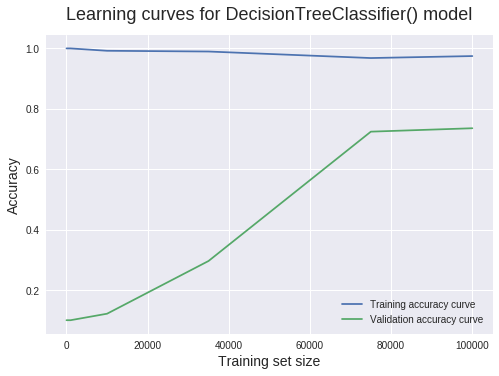

In [15]:
res_pred()               #Run the manual code

### Outlier detection via Box Plot

First of all, the translation to a list of the dataframe is needed in order to be processed by boxplot function

In [15]:
# Dataframe to list convertion process
X_tr_list=[]
for column in X_train.columns:
     
    # Storing the rows of a column
    # into a temporary list
    lis = X_train[column].tolist()
     
    # appending the temporary list
    X_tr_list.append(lis)

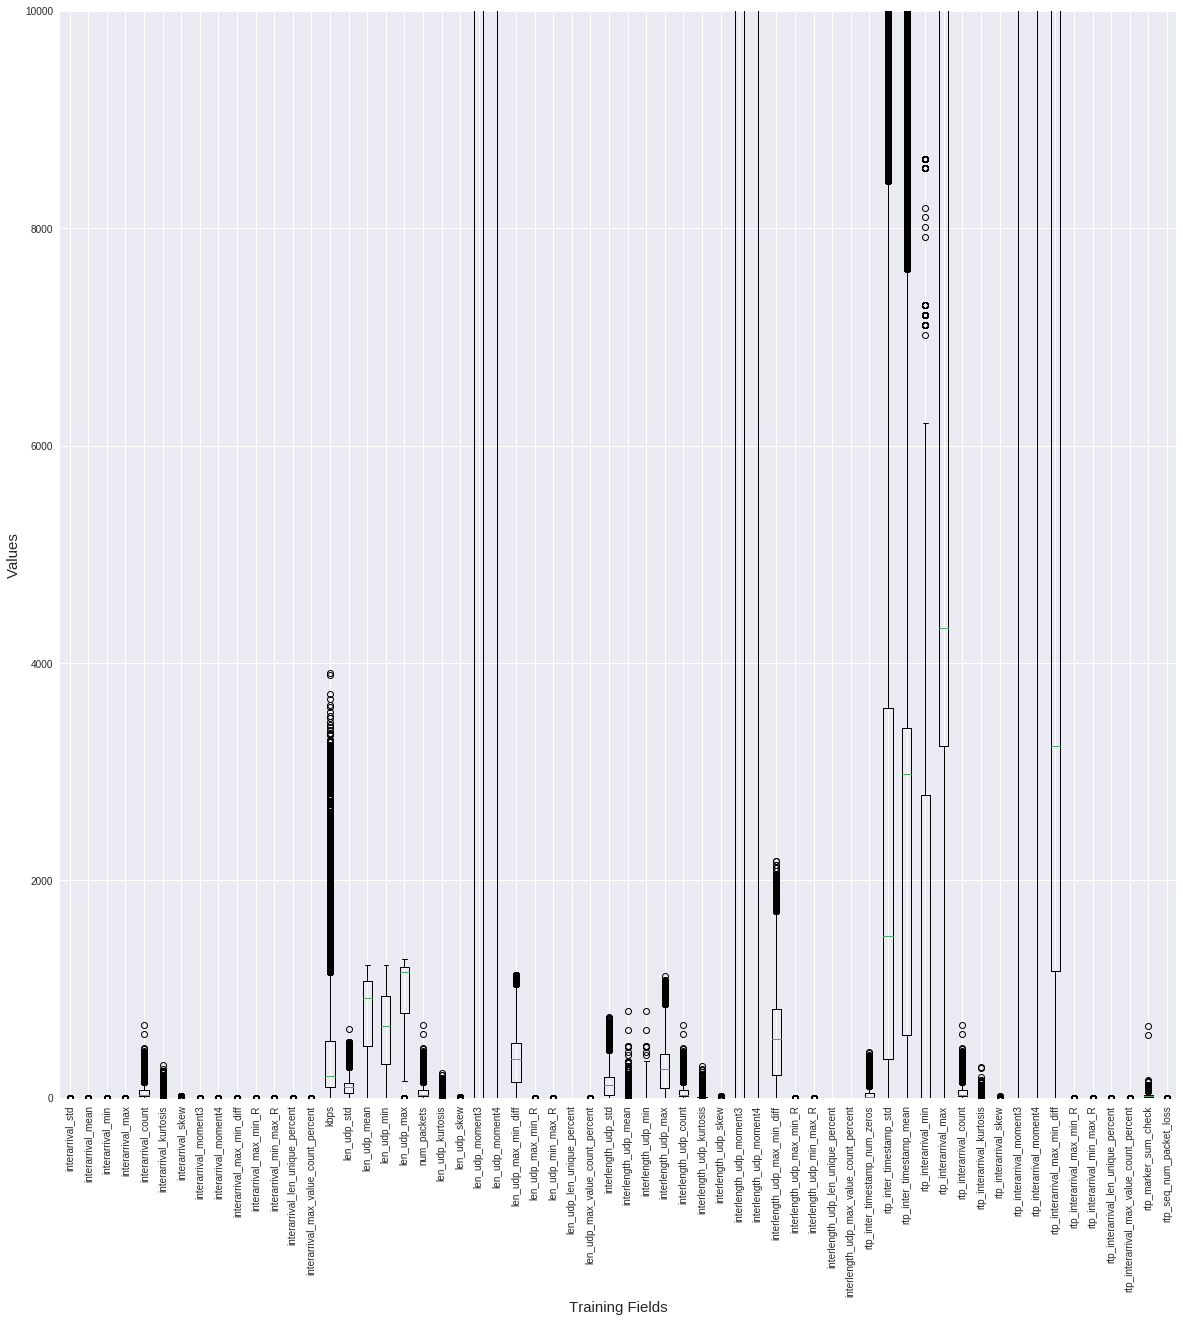

In [20]:
fig = plt.figure(figsize=(20,20))
ax = fig.subplots()
bp = ax.boxplot(X_tr_list)
ax.set(ylim=(0, 10000))
ax.set_xticklabels(X_train.columns,rotation=90)
ax.set_ylabel('Values',fontsize = 15)
ax.set_xlabel('Training Fields',fontsize = 15)
plt.show()

### Func-7) Automatic Run

In [29]:
def res_pred():                                                                 #create the function    
    
    methods = ["reduce", "group"]              #try among two methods: grouping the close classes together (group) or dropping classes below a threshold (reduce)
    for mt in methods:
        meth(mt)
    
        algorithms=["decisionTree", "xgboost", "randomForest"]
        for alg in algorithms:
            if alg == "decisionTree":                                                   #Check the input value and accordingly apply the next steps
                #outlier=input("Do you want to exctract outliers(yes or no): ")
                
                feat_selection=["no","yes"]
                for feat in feat_selection:
                    #inp_data()
                    if feat == "yes":
                        selection_method=["ExtraTree","infoGain","corrCoeff","anova_f"]
                        for feat_val in selection_method:
                            inp_data()
                            feat_sel(feat_val)             
                            print(f"These are the results for {mt} method, {alg} algorithm and {feat_val} feature selection method")
                            dec_tree()
                
                    elif feat == "no":
                        print(f"These are the results for {mt} method, {alg} algorithm and without using any feature selection method")
                        inp_data()
                        dec_tree()
        
            
            elif alg == "randomForest":                                                   #Check the input value and accordingly apply the next steps
                print(f"We are using {alg} algorithm")
                #outlier=input("Do you want to exctract outliers(yes or no): ")
                
                feat_selection=["no","yes"]
                for feat in feat_selection:
                    #inp_data()
                    if feat == "yes":
                        selection_method=["ExtraTree","infoGain","corrCoeff","anova_f"]
                        for feat_val in selection_method:
                            inp_data()
                            feat_sel(feat_val)             
                            print(f"These are the results for {mt} method, {alg} algorithm and {feat_val} feature selection method")
                            rand_for()
                
                    elif feat == "no":
                        inp_data()
                        print(f"These are the results for {mt} method, {alg} algorithm and without using any feature selection method")
                        rand_for()
          
        
            elif alg == "xgboost":                                                   #Check the input value and accordingly apply the next steps
                print(f"We are using {alg} algorithm")
                #outlier=input("Do you want to exctract outliers(yes or no): ")
                
                feat_selection=["no","yes"]
                for feat in feat_selection:
                    #inp_data()
                    if feat == "yes":
                        selection_method=["ExtraTree","infoGain","corrCoeff","anova_f"]
                        for feat_val in selection_method:
                            inp_data()
                            feat_sel(feat_val)             
                            print(f"These are the results for {mt} method, {alg} algorithm and {feat_val} feature selection method")
                            xg_bst()
                
                    elif feat == "no":
                        inp_data()
                        print(f"These are the results for {mt} method, {alg} algorithm and without using any feature selection method")
                        xg_bst()

In [12]:
python Resolution.py > out.txt

SyntaxError: invalid syntax (<ipython-input-12-58310806c04e>, line 1)

In [30]:
res_pred()

These are the results for reduce method, decisionTree algorithm and without using any feature selection method
[[ 2679   857    11     6     1     0     0]
 [  716 28040   206    12    37    10    23]
 [   12  1214  9716    51    48     2     0]
 [    9   117    27   811  1297     8     0]
 [    6  1243   309   625 11042    32    12]
 [    2     9     4     1     6  5001   455]
 [    4   133    32     1   256   830  1992]]
              precision    recall  f1-score   support

       240.0       0.78      0.75      0.77      3554
       320.0       0.89      0.97      0.92     29044
       640.0       0.94      0.88      0.91     11043
       960.0       0.54      0.36      0.43      2269
      1280.0       0.87      0.83      0.85     13269
      1396.0       0.85      0.91      0.88      5478
      2048.0       0.80      0.61      0.70      3248

    accuracy                           0.87     67905
   macro avg       0.81      0.76      0.78     67905
weighted avg       0.87      0.

#### Comment:
In this model it seems that feature selection does not improve the accuracy at all.

##### General Comment: 
Using another strong algorithm such as XG-BOOST, it is clearly proven that the low accuracy in the previous algorithm (Decision Tree) was not due to the algorithm used but as we predicted it may be due to the classes with lower and no support. By grouping closer classes together we observe a considerable accuracy improvement. Also when droping the classes below a threshold (i.e. 1000) we achieve a cosiderable performance improvement compared to the initial dataset.

#### Chi2 method (not working)

In [ ]:
# NOTE: Since chi2 does not accept negative values I am not able to run it

chi2_feat = SelectKBest(chi2, k=10)
X_kbest_feat = chi2_feat.fit_transform(X_train, y_train)

print("original: ", X_train.shape[1])
print("reduced: ", X_kbest_feat.shape[1])

### Verification of the input data correlation 

#### a) Coefficient Correlation

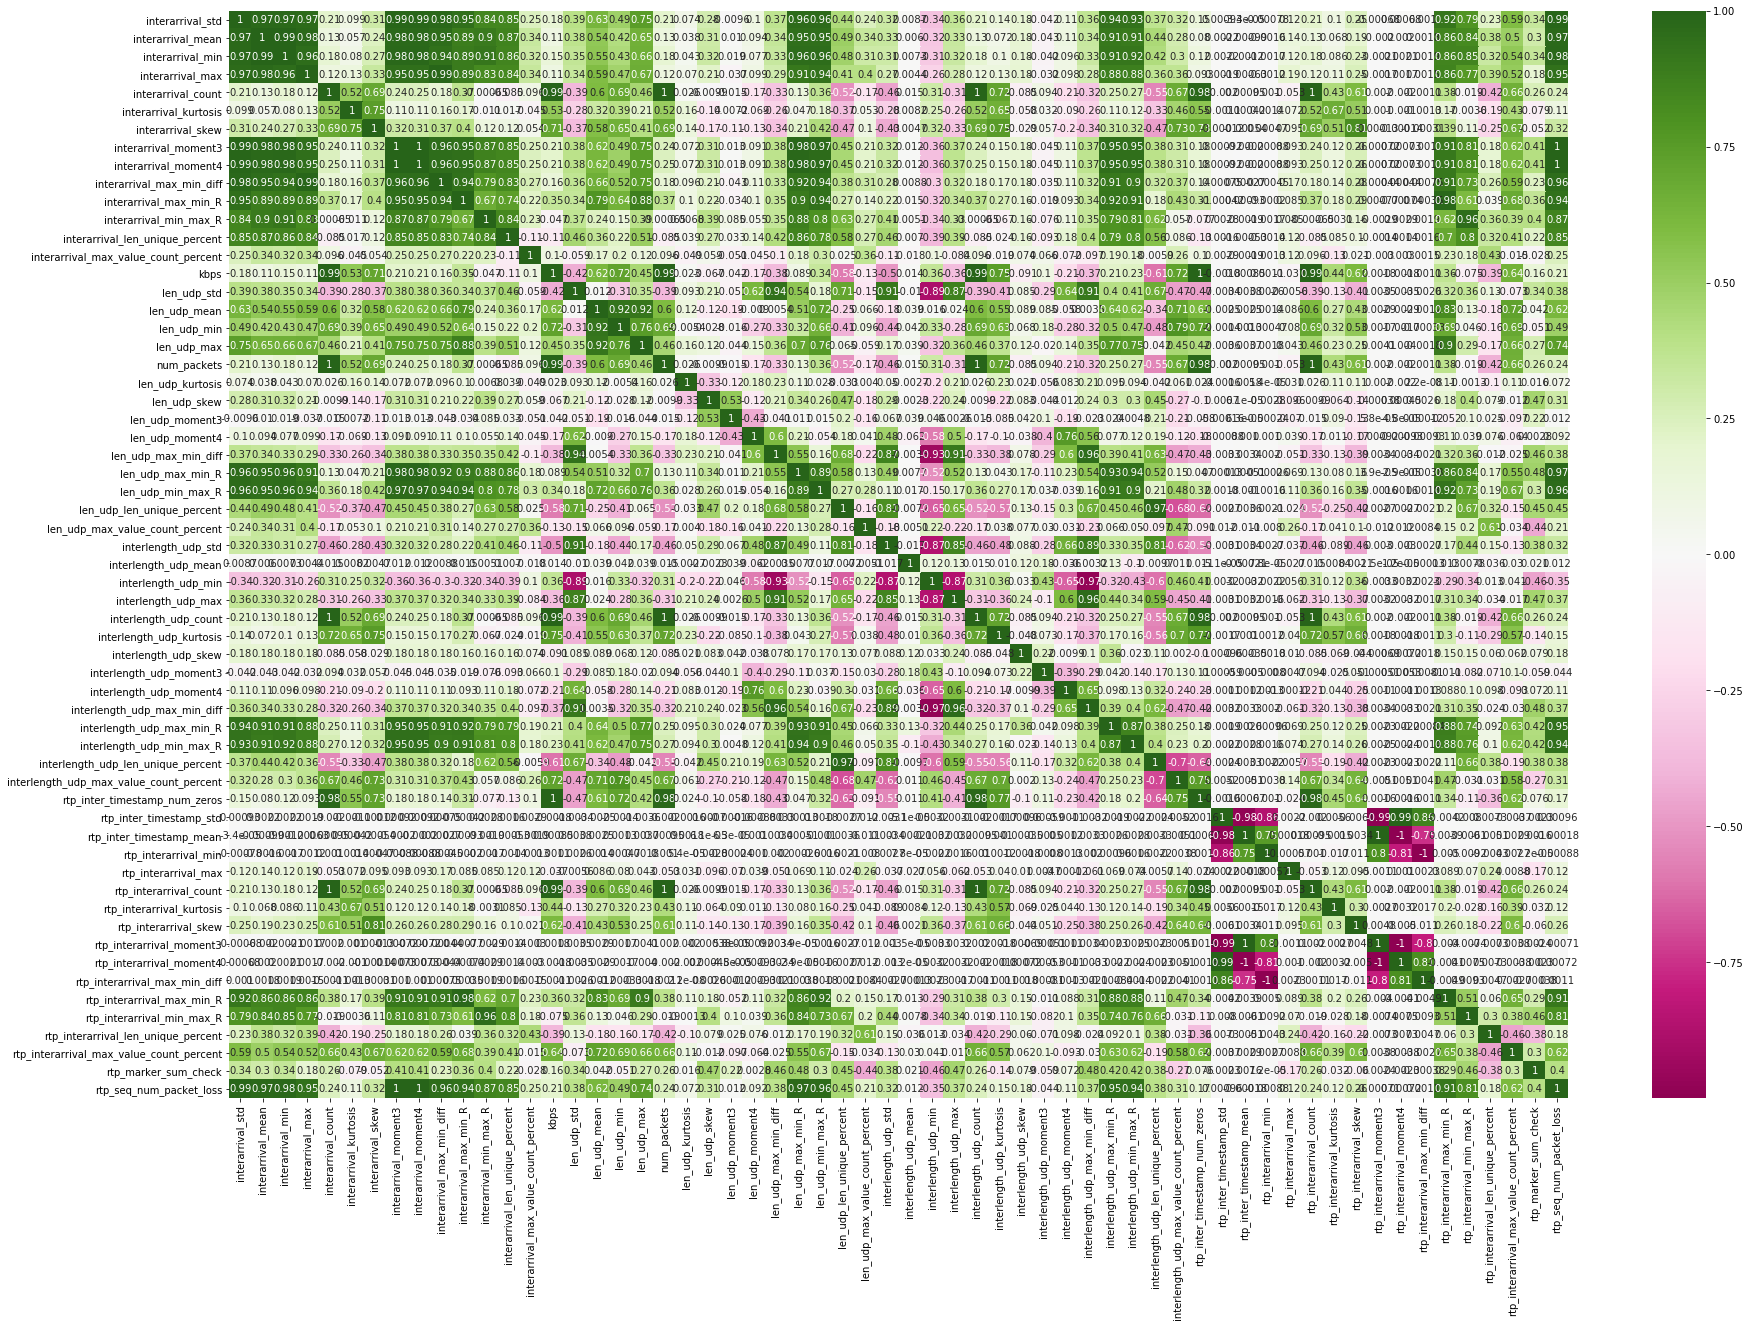

In [19]:
cor = X_train.corr()
plt.figure(figsize=(30,20))
sns.heatmap(cor,annot=True, cmap="PiYG")

In [28]:
X_train.shape

(168415, 31)

### Feature Selection

#### Method-1: ExtraTree Method

[0.06127637 0.05353043 0.04594426 0.04591814 0.05055341 0.04853891
 0.06168393 0.054915   0.04109594 0.04165545 0.02706381 0.02323251
 0.0297785  0.03187827 0.02549938 0.02482122 0.02793389 0.02280803
 0.02965496 0.01568666 0.0131741  0.01864298 0.01604044 0.01683573
 0.01477954 0.01630333 0.01654135 0.01927653 0.01454028 0.01064616
 0.01359479 0.01318796 0.01997334 0.0144932  0.0185012 ]


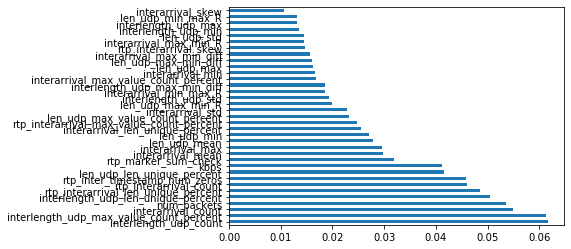

interlength_udp_count                       0.061684
interlength_udp_max_value_count_percent     0.061276
interarrival_count                          0.054915
num_packets                                 0.053530
interlength_udp_len_unique_percent          0.050553
rtp_interarrival_len_unique_percent         0.048539
rtp_interarrival_count                      0.045944
rtp_inter_timestamp_num_zeros               0.045918
len_udp_len_unique_percent                  0.041655
kbps                                        0.041096
rtp_marker_sum_check                        0.031878
interarrival_mean                           0.029779
interarrival_max                            0.029655
len_udp_mean                                0.027934
len_udp_min                                 0.027064
interarrival_len_unique_percent             0.025499
rtp_interarrival_max_value_count_percent    0.024821
len_udp_max_value_count_percent             0.023233
interarrival_std                            0.

In [42]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(35).plot(kind='barh')
plt.show()
print(feat_importances.nlargest(35))

### Try some other methods of Feature Selection (after reducing the number of classes)

Comment: By grouping the classes to the closest ones together we observe a considerable accuracy improvement. Now try by droping the classes with support below a threshold